# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [108]:
# Load pickled data
import pickle

training_file = "data/train.p"
validation_file= "data/valid.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
import numpy as np
import pandas as pd

# Number of training samples
n_train = np.shape(X_train)[0]

# Number of valid samples
n_valid = np.shape(X_valid)[0]

# Number of test samples
n_test = np.shape(X_test)[0]

# The shape of a traffic sign image - assuming the resized version of the training images (originals are all different)
image_shape = (np.shape(X_train)[1], np.shape(X_train)[2], np.shape(X_train)[3])

# Number of class - We concatenate all datasets just in case any set doesn't contain all labels
y_train_df = pd.DataFrame(data=y_train, columns=['label'])
y_valid_df = pd.DataFrame(data=y_valid, columns=['label'])
y_test_df = pd.DataFrame(data=y_test, columns=['label'])
y_composite_df = y_train_df.append(y_valid_df).append(y_test_df)
n_classes = len(y_composite_df.label.unique())

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

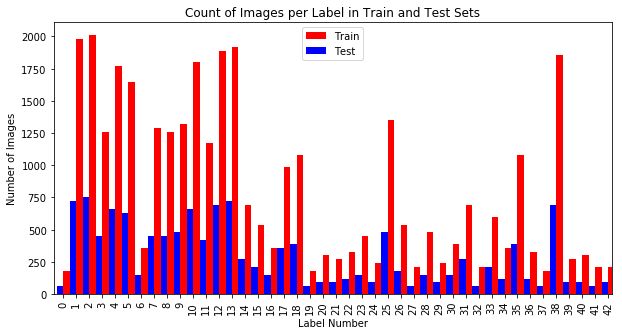

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.

# Plot the count of each label for training and test sets
#   We could potentially be over-fitting to a specific sign, or...
#   The datasets could be skewed to different signs

plt.figure(figsize=(10, 5))
labels_train_grouped = y_train_df.groupby(['label']).size()
labels_train_grouped.plot.bar(color='red', position=0, label='Train')
labels_test_grouped = y_test_df.groupby(['label']).size()
labels_test_grouped.plot.bar(color='blue', position=1, label='Test')
plt.title("Count of Images per Label in Train and Test Sets")
plt.legend()
plt.xlabel('Label Number')
plt.ylabel('Number of Images')
plt.show()

%matplotlib inline

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

### Pre-process the Data Set

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [5]:
### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.
### Feel free to use as many code cells as needed.

# Convert image data to grayscale
import cv2

def pre_process(x):
    # Grayscale
    data = np.asarray([np.reshape(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), (32,32,1)) for img in x])
    # Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    data_min = np.min(data)
    data_max = np.max(data)
    a = 0
    b = 1
    data_prime = a + (data - data_min)*(b-a)/(data_max - data_min)
    # Center the data
    data_mean = np.mean(data_prime)
    data_prime_ctr = data_prime - data_mean
    
    return data_prime_ctr

### Model Architecture

In [72]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import math

# Define our keep probability for the dropout layer - This should only be something other than 1.0 when training
keep_prob = tf.placeholder(tf.float32)

def ConvNet(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    c1_f_height, c1_f_width = getValidFilterSize(32, 32, 28, 28)
    c1_weights = tf.Variable(tf.truncated_normal(shape=(c1_f_height, c1_f_width, 1, 6), mean=mu, stddev=sigma))
    c1_bias = tf.Variable(tf.zeros(6))
    c1 = conv2d(x, c1_weights, c1_bias, stride=1, padding="VALID")
    
    # Layer 1: Activation.
    c1 = tf.nn.relu(c1)

    # Layer 1: Pooling. Input = 28x28x6. Output = 14x14x6. Non-overlapping        
    c1 = maxpool2d(c1, padding='VALID')
                             
    # Layer 2: Convolutional. Input = 14x14x6. Output = 10x10x16.
    c2_f_height, c2_f_width = getValidFilterSize(14, 14, 10, 10)
    c2_weights = tf.Variable(tf.truncated_normal(shape=(c2_f_height, c2_f_width, 6, 16), mean=mu, stddev=sigma))
    c2_bias = tf.Variable(tf.zeros(16))
    c2 = conv2d(c1, c2_weights, c2_bias, stride=1, padding="VALID")
    
    # Layer 2: Activation.
    c2 = tf.nn.relu(c2)

    # Layer 2: Pooling. Input = 10x10x16. Output = 5x5x16.
    c2 = maxpool2d(c2, padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0 = flatten(c2)                       
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_weights = tf.Variable(tf.truncated_normal(shape=(400, 120), mean=mu, stddev=sigma))
    fc1_bias = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc0, fc1_weights) + fc1_bias
   
    # Layer 3: Activation.
    fc1 = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_weights = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma))
    fc2_bias = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1, fc2_weights) + fc2_bias
                                  
    # Layer 4: Activation.
    fc2 = tf.nn.relu(fc2)
        
    # Layer 4: Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_weights = tf.Variable(tf.truncated_normal(shape=(84, 43), mean=mu, stddev=sigma))
    fc3_bias = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_weights) + fc3_bias
                              
    return logits
                       

def conv2d(x, W, b, stride=1, padding='VALID'):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding=padding) + b

def maxpool2d(x, k=2, padding='VALID'):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding=padding)
        
def getValidFilterSize(in_height, in_width, out_height, out_width, stride=1):
    """
    Given an input feature map height and width for a filter with VALID padding and given stride, return the 
    filter height and width that achieves the given output heigth and width
    """
    f_height = in_height + 1 - out_height * stride
    f_width = in_width + 1 - out_height * stride
    if (f_height < 1 or f_width < 1):
        raise ValueError("Illegal combination of in/out height/width and stride resulting in invalid filter dimensions")
    return f_height, f_width

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [102]:
# Training Parameters
EPOCHS = 10
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [103]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

logits = ConvNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)

In [104]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [106]:
from sklearn.utils import shuffle

saver = tf.train.Saver()
save_file = "./convnet"

X_train_pp = pre_process(np.copy(X_train))
y_train_pp = np.copy(y_train)
X_valid_pp = pre_process(np.copy(X_valid))
y_valid_pp = np.copy(y_valid)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_pp)

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_pp, y_train_pp = shuffle(X_train_pp, y_train_pp)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_pp[offset:end], y_train_pp[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.50})
        print("EPOCH {} ...".format(i+1))
        training_accuracy = evaluate(X_train_pp, y_train_pp)
        print("Training Set Accuracy = {:.3f}".format(training_accuracy))
        validation_accuracy = evaluate(X_valid_pp, y_valid_pp)
        print("Validation Set Accuracy = {:.3f}".format(validation_accuracy))
        
    saver.save(sess, save_file)
    print("Model saved")

Training...

EPOCH 1 ...
Training Set Accuracy = 0.834
Validation Set Accuracy = 0.772
EPOCH 2 ...
Training Set Accuracy = 0.925
Validation Set Accuracy = 0.878
EPOCH 3 ...
Training Set Accuracy = 0.954
Validation Set Accuracy = 0.900
EPOCH 4 ...
Training Set Accuracy = 0.974
Validation Set Accuracy = 0.920
EPOCH 5 ...
Training Set Accuracy = 0.978
Validation Set Accuracy = 0.937
EPOCH 6 ...
Training Set Accuracy = 0.984
Validation Set Accuracy = 0.941
EPOCH 7 ...
Training Set Accuracy = 0.987
Validation Set Accuracy = 0.944
EPOCH 8 ...
Training Set Accuracy = 0.990
Validation Set Accuracy = 0.951
EPOCH 9 ...
Training Set Accuracy = 0.992
Validation Set Accuracy = 0.944
EPOCH 10 ...
Training Set Accuracy = 0.995
Validation Set Accuracy = 0.945
Model saved


In [109]:
with tf.Session() as sess:
    saver.restore(sess, save_file)
    test_accuracy = evaluate(pre_process(X_test), y_test)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))

Test Set Accuracy = 0.922


---

## Step 3: Test a Model on New Images

Download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

### Load and Output the Images

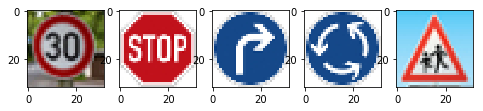

In [110]:
### Load the images and plot them here.
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline

# Load the images into X_new and y_new arrays
X_new = []
y_new = []

for file in os.listdir("testImages"):
    img = cv2.cvtColor(cv2.imread("testImages/" + file), cv2.COLOR_BGR2RGB) # imread reads files BGR but we need RGB
    label = file.split(".")[0].split("_")[1]
    X_new.append(img)
    y_new.append(label)
    
X_new = np.asarray(X_new)
y_new = np.asarray(y_new)

# Plot the images
plt.figure(figsize=(8,3))
i=1
for img in X_new:
    ax = plt.subplot(1,5,i)
    plt.imshow(img)
    i += 1

### Predict the Sign Type for Each Image

In [111]:
### Prediction the label for each new image.
import tensorflow as tf

prediction = tf.argmax(logits,1)

with tf.Session() as sess:
    # Reload the saved model
    saver.restore(sess, save_file)
    print("Predicted: ")
    print(sess.run(prediction, feed_dict={x: pre_process(X_new), keep_prob: 1.0}))
    print("Actual: ")
    print([int(val) for val in y_new])

Predicted: 
[ 1 14 33 40 28]
Actual: 
[1, 14, 33, 40, 28]


### Analyze Performance

In [112]:
### Calculate the accuracy for these 5 new images. 

with tf.Session() as sess:
    saver.restore(sess, save_file)
    test_accuracy = evaluate(pre_process(X_new), y_new)
    print("New Image Accuracy = {:.3f}".format(test_accuracy))

New Image Accuracy = 1.000


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [114]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    saver.restore(sess, save_file)
    prediction = tf.nn.softmax(logits)
    print(sess.run(tf.nn.top_k(prediction, k=5), feed_dict={x: pre_process(X_new), keep_prob: 1.0}))

TopKV2(values=array([[  5.37398100e-01,   4.62555379e-01,   4.50176558e-05,
          1.47699700e-06,   4.73866363e-11],
       [  8.28190088e-01,   1.55861080e-01,   1.49630122e-02,
          8.42884416e-04,   1.31976471e-04],
       [  1.00000000e+00,   3.22184901e-09,   6.05238732e-12,
          5.89465239e-12,   3.86949003e-15],
       [  9.99836683e-01,   1.61768752e-04,   9.70686870e-07,
          3.74547000e-07,   1.28573106e-07],
       [  1.00000000e+00,   3.96120612e-08,   2.11690954e-09,
          2.37768583e-10,   7.49340243e-11]], dtype=float32), indices=array([[ 1,  2,  3,  5, 15],
       [14,  8,  2,  4, 15],
       [33,  1, 11, 14, 25],
       [40, 11,  1, 12,  7],
       [28, 20, 23, 30, 29]], dtype=int32))


---

## Step 4: Visualize the Neural Network's State with Test Images

This Section was not completed for this report